## Welcome!

In this notebook we calculate Stored Carbon from an ISRIC dataset, more specifically the ISRIC-WISE Harmonized Global Soil Profile Dataset v3.1 available here: https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/a351682c-330a-4995-a5a1-57ad160e621c"

The dataset (in MS Access format) was downloaded and split into .csv files, available in a .zip here:

https://drive.google.com/file/d/1wuhyplJ7klD4hV7BsAGSalnXjc5a4GK4/view?usp=sharing

In [1]:
using Pkg

In [2]:
Pkg.add(["Plots","DataFrames", "CSV", "Query", "StatsBase", "Interpolations"])

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [3]:
using Plots, DataFrames, CSV, Query, StatsBase, Interpolations

Let's import the soil horizon data:

In [4]:
df_horizon = CSV.read(download("https://drive.google.com/uc?export=download&id=1dAHPZfm8KIXC9qVks-owkD0LYbZjPpIM"), DataFrame)

┌ Warning: thread = 1 warning: only found 30 / 31 columns around data row: 47834. Filling remaining columns with `missing`
└ @ CSV /Users/Daniele/.julia/packages/CSV/la2cd/src/file.jl:603


,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,MCOLOR,DCOLOR,ORGC,TOTN,CACO3
,String,Int64,String?,Int64,Int64,String?,String?,String?,String?,String?
1,AF0001,1,missing,0,15,10YR4/3,10YR4/2,"7,6","0,6",93
2,AF0001,2,missing,15,60,10YR5/3,10YR5/2,"2,3","0,3",177
3,AF0001,3,missing,60,150,10YR5/3,missing,"0,9","0,3",182
4,AF0002,1,missing,0,20,10YR4/2,missing,"12,8","0,9",191
5,AF0002,2,missing,20,60,10YR4/2,missing,6,"0,6",192
6,AF0002,3,missing,60,110,10YR4/3,missing,"3,9","0,6",203
7,AF0002,4,missing,110,170,10YR4/3,missing,"2,7",missing,240
8,AF0003,1,A,0,20,10YR4/2,missing,"5,9","0,7",169
9,AF0003,2,Bg,20,50,10YR4/2,missing,"2,4","0,4",138


Some cleaning is necessary:

In [5]:

filt_hz = df_horizon[:,[:WISE3_ID,:HONU,:DESIG,:TOPDEP,:BOTDEP,:ORGC,:BULKDENS]]

    dropmissing!(filt_hz,[:BULKDENS,:ORGC,:TOPDEP,:BOTDEP])	

    #BULKDENS and ORGC are still strings
    filt_hz.BULKDENS = tryparse.(Float64,replace.(filt_hz.BULKDENS,','=>'.'))
    filt_hz.ORGC = tryparse.(Float64,replace.(filt_hz.ORGC,','=>'.'))

    filt_hz


,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,ORGC,BULKDENS
,String,Int64,String?,Int64,Int64,Float64,Float64
1,AL0007,1,Ap,0,25,9.8,1.64
2,AL0007,2,AB,25,49,7.8,1.62
3,AL0007,3,Bw1,49,83,5.9,1.57
4,AL0007,4,Bw2,83,116,6.9,1.63
5,AL0007,5,2C1,116,147,4.6,1.56
6,AL0007,6,2C2,147,160,4.6,1.45
7,AL0008,1,Ap-,0,17,11.5,1.61
8,AL0008,2,Bw1,17,38,8.1,1.55
9,AL0008,3,2Bw2,38,66,1.7,1.18


In [6]:
v_double(vect) = [vect[Int(ceil(i/2))] for i in 1:length(vect)*2]

v_double (generic function with 1 method)

As measurements represent an average the whole profile section, I'm using a constant interpolation between TOP and BOT depth of each section:

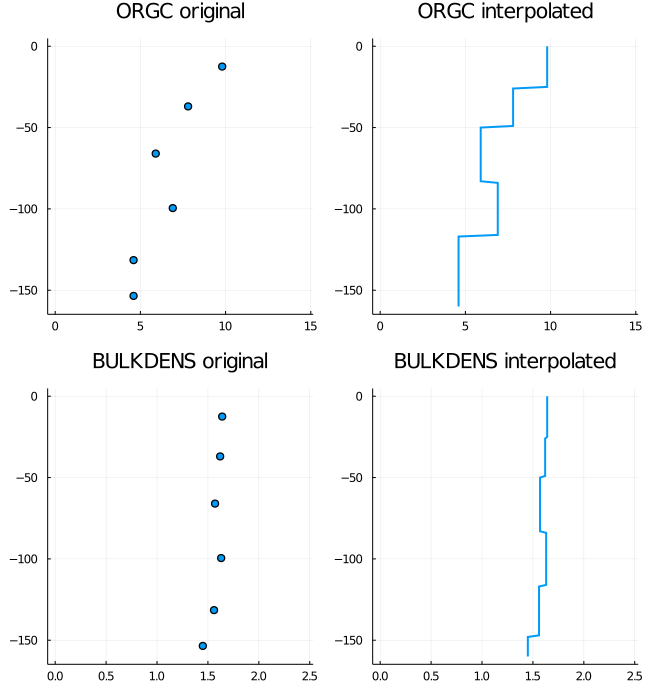

In [7]:

profile = filt_hz[filt_hz.WISE3_ID.=="AL0007",:]

#top and bottom for each section
td = profile.TOPDEP
bp = profile.BOTDEP

#values
blk = profile.BULKDENS
orgc = profile.ORGC	

#plotting utilities
y_mid = (td .+ bp)./2 #mid-depth for each measurement section within a profile
y_lim = [-maximum(bp),minimum(td)]
x_lim_orgc = [0,maximum(orgc)*1.5]
x_lim_blk = [0,maximum(blk)*1.5]

#merge TOP and BOT depth vectors	
y_sections = sort!(cat(td,bp, dims=1))
y_linear = [i for i in minimum(td):maximum(bp)]

#duplicate ORGC readings at each TOP/BOT end (for later interpolation)
orgc_ends = v_double(orgc) 
blk_ends = v_double(blk) 

#interpolation up to SOLDEP (= Max BOTDEP for profile) - given how the arrays are built, the results are the same as if we'd used a constant interpolation alg

orgc_interp = LinearInterpolation(y_sections, orgc_ends)
orgc_calc = orgc_interp.(y_linear)

blk_interp = LinearInterpolation(y_sections, blk_ends)
blk_calc = blk_interp.(y_linear)

# ORGC plot, original values
p_orgc_or=scatter(orgc,-y_mid, legend=nothing, xlim=x_lim_orgc, ylim=y_lim, title="ORGC original")

# ORGC plot, interpolated values
p_orgc_in = plot(orgc_calc,-y_linear, legend=nothing, xlim=x_lim_orgc, linewidth=2, ylim=y_lim, title="ORGC interpolated")

# BULKDENS plot, original values
p_blk_or =scatter(blk,-y_mid, legend=nothing, xlim=x_lim_blk, ylim=y_lim, title="BULKDENS original")

# BULKDENS plot, interpolated values
p_blk_in = plot(blk_calc,-y_linear, legend=nothing, xlim=x_lim_blk, linewidth=2, ylim=y_lim, title="BULKDENS interpolated")


plot(p_orgc_or, p_orgc_in, p_blk_or, p_blk_in, layout=4, size=(650,700))



As we have (interpolated) BULKDENS and ORGC values for each 1cm slice of soil, from 1cm to SOLDEP of depth, we can now calculate total ORGC stored in 1m²xSOLDEP of soil.

Given the dataset, we'll have to calculate storage as:\
BULKDENS [g / cm³] x AREA [m²] x ORGC [g / Kg] down to SOLDEP, 1cm at a time

The result will be in Kgs.

Generalizing the approach above, I define a function that I can call on each profile:

In [8]:
function orgc_storage_int(profile) 

top = profile.TOPDEP
bot = profile.BOTDEP

blk_temp = profile.BULKDENS
orgc_temp = profile.ORGC

y_linear = [i for i in minimum(top):maximum(bot)]

#doubled vectors for use in interpolation
y_sections = sort!(cat(top,bot,dims=1)) 	
orgc = v_double(orgc_temp)
blk = v_double(blk_temp) 

#interpolation
orgc_interp = LinearInterpolation(y_sections,orgc)
orgc_values = orgc_interp.(y_linear)

blk_interp = LinearInterpolation(y_sections,blk)
blk_values = blk_interp.(y_linear)

#ORGC mass calculation	(1cm x 1m² slices)
stored_orgc = [blk_values[i]*orgc_values[i]*(1/100) for i in 1:length(y_linear)]

return sum(stored_orgc) 


end


orgc_storage_int (generic function with 1 method)

I also define a function to calculate the stored ORGC in a simpler way:

In [9]:
function orgc_storage_std(profile) 

top = profile.TOPDEP
bot = profile.BOTDEP

blk = profile.BULKDENS
orgc = profile.ORGC

soldep = maximum(bot) #[cm]

section_height = (bot.-top)

mass=0.0
for sc in 1:length(section_height)

    mass += blk[sc]*orgc[sc]*section_height[sc]/100
end

return mass
end


orgc_storage_std (generic function with 1 method)

I call both functions on each profile in the dataset:

In [10]:

soil_profiles = unique(filt_hz.WISE3_ID)

orgc_mass_int = Dict()
orgc_mass_std = Dict()


for prof in soil_profiles
    orgc_mass_int[prof] = orgc_storage_int(filt_hz[filt_hz.WISE3_ID.==prof,:])
    orgc_mass_std[prof] = orgc_storage_std(filt_hz[filt_hz.WISE3_ID.==prof,:])
end



In [11]:
c_storage_interp = sum(values(orgc_mass_int)); c_storage_std = sum(values(orgc_mass_std))

45229.17349360983

In [12]:
c_storage_interp - c_storage_std

3311.101578169495

There seems to be a 3tons difference in storage depending on the method used, with std being more conservative.

Turn results stored in Dict to DF

In [13]:
stored_ORGC_int = sort!(DataFrame(WISE3_ID = String.(keys(orgc_mass_int)), 
                                STORED_ORGC = Float64.(values(orgc_mass_int))));

In [14]:
stored_ORGC_std = sort!(DataFrame(WISE3_ID = String.(keys(orgc_mass_std)), 
                                    STORED_ORGC = Float64.(values(orgc_mass_std))));

Let's enrich the data with extra information for each profile:

In [15]:
df_site = CSV.read(download("https://drive.google.com/uc?export=download&id=1mki-fWQDwmoimO87TxboJJA69usr66P_"), DataFrame)

,WISE3_id,ISO,DESCR,DATEYR,DATEMON,SOLDEP,HORNUM,FAO_90,PHA_90,FAO_74
,String,String,Int64,Int64?,Int64?,Int64,Int64,String,String?,String?
1,AF0001,AF,3,1962,missing,150,3,CLl,missing,Bk
2,AF0002,AF,3,1962,missing,170,4,FLc,missing,Jc
3,AF0003,AF,3,1962,missing,110,3,FLc,missing,Jc
4,AF0004,AF,3,1962,missing,270,6,SCg,missing,Zo
5,AF0005,AF,3,1962,missing,190,6,SCk,missing,Zo
6,AL0001,AL,4,1981,9,94,4,LVk,missing,Lk
7,AL0002,AL,4,1983,9,87,3,LPk,missing,Be
8,AL0003,AL,4,1985,12,85,3,LVf,missing,Lf
9,AL0004,AL,4,1991,11,120,6,CMc,missing,Bk


Pick only relevant columns from the SITE dataset:

In [16]:
filt_site = df_site[:,[:WISE3_id, :DATEYR, :SOLDEP, :LONDD, :LATDD]]

    rename!(filt_site,:WISE3_id => :WISE3_ID)

    dropmissing!(filt_site,[:LONDD,:LATDD])	

    filt_site.LONDD = tryparse.(Float64,replace.(filt_site.LONDD,','=>'.'))
    filt_site.LATDD = tryparse.(Float64,replace.(filt_site.LATDD,','=>'.'))

    filt_site


,WISE3_ID,DATEYR,SOLDEP,LONDD,LATDD
,String,Int64?,Int64,Float64,Float64
1,AF0001,1962,150,69.1667,34.5
2,AF0002,1962,170,69.1667,34.5
3,AF0003,1962,110,69.1667,34.5
4,AF0004,1962,270,61.4333,34.3333
5,AF0005,1962,190,62.1333,32.3833
6,AL0001,1981,94,20.75,40.6167
7,AL0002,1983,87,20.3006,39.635
8,AL0003,1985,85,20.3861,42.2222
9,AL0004,1991,120,19.5611,41.0778


In [17]:
min_tops = filt_hz[filt_hz.HONU .== 1, [:WISE3_ID,:TOPDEP]]

,WISE3_ID,TOPDEP
,String,Int64
1,AL0007,0
2,AL0008,0
3,AL0009,0
4,AL0010,0
5,AL0011,0
6,AL0012,0
7,AL0013,0
8,AL0014,0
9,AL0015,0


Let's join the computed results with data from SITE:

In [18]:
#add location data
int_joinLoc = innerjoin(stored_ORGC_int, filt_site, on = :WISE3_ID)

#add min_tops data
int_joinTops = innerjoin(int_joinLoc, min_tops, on = :WISE3_ID)

#change cols order
stored_ORGC_int_ds = int_joinTops[!,[:WISE3_ID,:STORED_ORGC,:DATEYR,:LONDD,:LATDD,:TOPDEP,:SOLDEP]]

#rename top col
rename!(stored_ORGC_int_ds,:TOPDEP => :MINTOP)



,WISE3_ID,STORED_ORGC,DATEYR,LONDD,LATDD,MINTOP,SOLDEP
,String,Float64,Int64?,Float64,Float64,Int64,Int64
1,AL0007,17.164,1994,19.9956,41.0694,0,160
2,AL0008,6.98483,1994,20.6472,40.215,0,100
3,AL0009,10.3603,1994,20.7844,40.6372,0,110
4,AL0010,16.4571,1994,19.4836,40.3453,0,110
5,AL0011,19.7915,1994,19.7703,41.3778,0,130
6,AL0012,12.868,1994,20.9589,40.6553,0,173
7,AL0013,14.5514,1994,20.7325,40.5644,0,180
8,AL0014,13.8804,1994,20.4064,41.6928,0,130
9,AL0015,24.1183,1994,19.7625,41.37,0,180


In [19]:
begin

#add location data
std_joinLoc = innerjoin(stored_ORGC_std, filt_site, on = :WISE3_ID)

#add min_tops data
std_joinTops = innerjoin(std_joinLoc, min_tops, on = :WISE3_ID)

#change cols order
stored_ORGC_std_ds = std_joinTops[!,[:WISE3_ID,:STORED_ORGC,:DATEYR,:LONDD,:LATDD,:TOPDEP,:SOLDEP]]

#rename top col
rename!(stored_ORGC_std_ds,:TOPDEP => :MINTOP)
end

,WISE3_ID,STORED_ORGC,DATEYR,LONDD,LATDD,MINTOP,SOLDEP
,String,Float64,Int64?,Float64,Float64,Int64,Int64
1,AL0007,17.0032,1994,19.9956,41.0694,0,160
2,AL0008,6.79968,1994,20.6472,40.215,0,100
3,AL0009,10.19,1994,20.7844,40.6372,0,110
4,AL0010,16.182,1994,19.4836,40.3453,0,110
5,AL0011,19.5227,1994,19.7703,41.3778,0,130
6,AL0012,12.7518,1994,20.9589,40.6553,0,173
7,AL0013,14.3507,1994,20.7325,40.5644,0,180
8,AL0014,13.6746,1994,20.4064,41.6928,0,130
9,AL0015,23.7756,1994,19.7625,41.37,0,180


The results (for the standard calculation) can be accessed here:

https://drive.google.com/file/d/12UVsNtkLS3EXq1hS-wBcM0sl1-VUwp5N/view?usp=sharing